In [3]:
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

In [4]:
df = pd.read_csv("/Users/tomiwa/Downloads/Cleaned_Reddit_Data.csv")

In [5]:
vader = SentimentIntensityAnalyzer()

In [6]:
df["compound_score"] = df["cleaned_text"].apply(lambda text: vader.polarity_scores(text)["compound"])

In [7]:
# Classifying sentiments
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment"] = df["compound_score"].apply(classify_sentiment)

In [8]:
 print(df[["cleaned_text", "compound_score", "sentiment"]].head())

                                        cleaned_text  compound_score sentiment
0  jagmeet singhs plan invest in building 500000 ...          0.9509  Positive
1  canada economy in decline trying to save housi...          0.9982  Positive
2  unpopular opinion housing should not be an inv...         -0.9599  Negative
3  people really arent angry enough about economi...         -0.9595  Negative
4  why you should care about housing affordabilit...          0.9971  Positive


Insights Using VASDER

In [9]:
sentiment_counts = df["sentiment"].value_counts()
print(sentiment_counts) 

sentiment
Positive    119
Negative     68
Neutral      13
Name: count, dtype: int64


In [10]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'im', 'ive', 'dont', 'cant', 'get', 'one', 'like', 'also', 'would', 'could', 'still',
    'even', 'really', 'say', 'see', 'much', 'many', 'make', 'go', 'come', 'know', 'think',
    'thing', 'things', 'back', 'year', 'years', 'need', 'want', 'well', 'way', 'people',
    'just', 'going', 'got', 'live', 'every', 'something', 'rent', 'housing', 'home', 
    'house', 'city', 'province', 'canada', 'toronto', 'vancouver', 'ottawa'
])

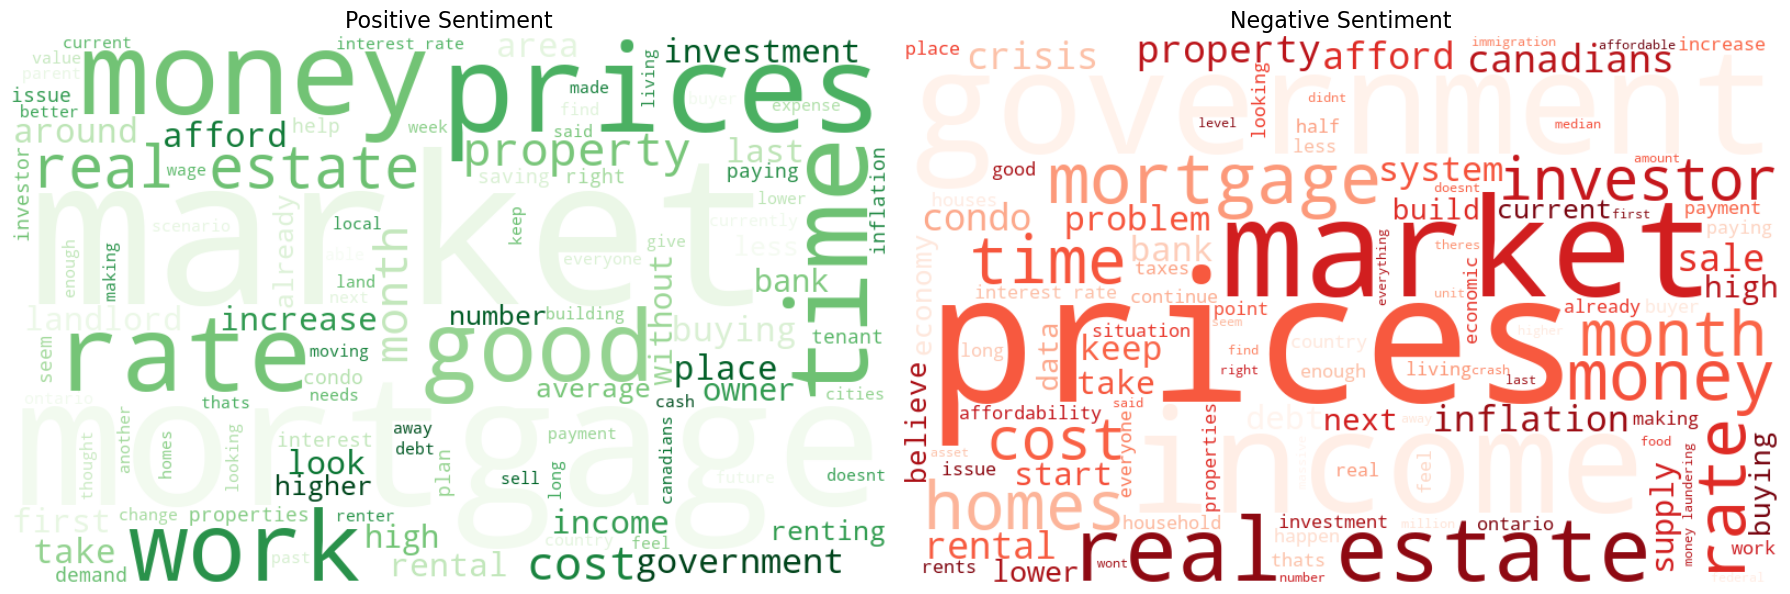

In [11]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'im', 'ive', 'dont', 'cant', 'get', 'one', 'like', 'also', 'would', 'could', 'still',
    'even', 'really', 'say', 'see', 'much', 'many', 'make', 'go', 'come', 'know', 'think',
    'thing', 'things', 'back', 'year', 'years', 'need', 'want', 'well', 'way', 'people',
    'just', 'going', 'got', 'live', 'every', 'something', 'rent', 'housing', 'home', 
    'house', 'city', 'province', 'canada', 'toronto', 'vancouver', 'ottawa', 'will', 'canadian', 'getting', 'move','real estate','price'
])


def clean_text_for_wordcloud(df_subset):
    text = " ".join(df_subset["cleaned_text"]).lower()
    words = re.findall(r'\b[a-z]{4,}\b', text)
    return " ".join([word for word in words if word not in custom_stopwords])


positive_text = clean_text_for_wordcloud(df[df["sentiment"] == "Positive"])
negative_text = clean_text_for_wordcloud(df[df["sentiment"] == "Negative"])


wordcloud_pos = WordCloud(
    width=800, height=500, background_color='white',
    colormap='Greens', stopwords=custom_stopwords,
    max_words=100, contour_color='green', contour_width=1
).generate(positive_text)

wordcloud_neg = WordCloud(
    width=800, height=500, background_color='white',
    colormap='Reds', stopwords=custom_stopwords,
    max_words=100, contour_color='red', contour_width=1
).generate(negative_text)


plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Sentiment", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Sentiment", fontsize=16)
plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
def get_top_words(df_subset, n=10):
    text = " ".join(df_subset["cleaned_text"]).lower()
    words = re.findall(r'\b[a-z]{4,}\b', text)
    filtered_words = [w for w in words if w not in custom_stopwords]
    return Counter(filtered_words).most_common(n)

# Get top words for each sentiment
top_positive = get_top_words(df[df['sentiment'] == 'Positive'])
top_negative = get_top_words(df[df['sentiment'] == 'Negative'])
top_neutral = get_top_words(df[df['sentiment'] == 'Neutral'])

print("Top Positive Words:", top_positive)
print("Top Negative Words:", top_negative)
print("Top Neutral Words:", top_neutral)

Top Positive Words: [('market', 149), ('prices', 143), ('mortgage', 134), ('money', 117), ('time', 116), ('real', 108), ('property', 104), ('rates', 95), ('estate', 92), ('work', 84)]
Top Negative Words: [('prices', 111), ('market', 75), ('real', 74), ('government', 73), ('income', 72), ('money', 68), ('rates', 59), ('estate', 55), ('homes', 48), ('time', 45)]
Top Neutral Words: [('rents', 3), ('canadians', 3), ('prices', 2), ('renting', 2), ('jump', 2), ('homelessness', 1), ('explodes', 1), ('soar', 1), ('opinion', 1), ('boom', 1)]


Trying to get the top words in for each sentiment is not very insightful in my opinion so I'm using Term Frequency-Inverse Document Frequency (TF-IDF) to surface what makes each sentiment class different.

In [13]:
pos_texts = df[df['sentiment'] == 'Positive']['cleaned_text']
neg_texts = df[df['sentiment'] == 'Negative']['cleaned_text']
neu_texts = df[df['sentiment'] == 'Neutral']['cleaned_text']

# Function to get top TF-IDF words
def get_top_tfidf_words(texts, n=10):
    vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), max_features=1000)
    X = vectorizer.fit_transform(texts)
    avg_tfidf = X.mean(axis=0).A1
    top_indices = avg_tfidf.argsort()[-n:][::-1]
    feature_names = vectorizer.get_feature_names_out()
    top_words = [(feature_names[i], round(avg_tfidf[i], 4)) for i in top_indices]
    return top_words

print("🔷 Top Positive TF-IDF Words:", get_top_tfidf_words(pos_texts))
print("🔴 Top Negative TF-IDF Words:", get_top_tfidf_words(neg_texts))
print("⚪ Top Neutral TF-IDF Words:", get_top_tfidf_words(neu_texts))

🔷 Top Positive TF-IDF Words: [('market', 0.0392), ('buy', 0.0371), ('prices', 0.0361), ('money', 0.0349), ('mortgage', 0.0335), ('canadians', 0.0334), ('real', 0.0312), ('property', 0.0304), ('rates', 0.0287), ('estate', 0.0285)]
🔴 Top Negative TF-IDF Words: [('prices', 0.0532), ('market', 0.0426), ('government', 0.0407), ('investors', 0.0393), ('income', 0.0351), ('money', 0.035), ('homes', 0.0348), ('real', 0.0309), ('canadians', 0.0307), ('crisis', 0.0304)]
⚪ Top Neutral TF-IDF Words: [('rents', 0.0766), ('prices', 0.0662), ('canadians', 0.061), ('jump', 0.0536), ('renting', 0.0507), ('foreign', 0.0398), ('buyers', 0.0398), ('driving', 0.0398), ('homelessness', 0.037), ('major', 0.037)]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'estate', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'real', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


/var/folders/1v/t2nqbf2170s4f9z_0swmfcw00000gn/T/ipykernel_78695/1054421906.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(words), palette='Greens_r')


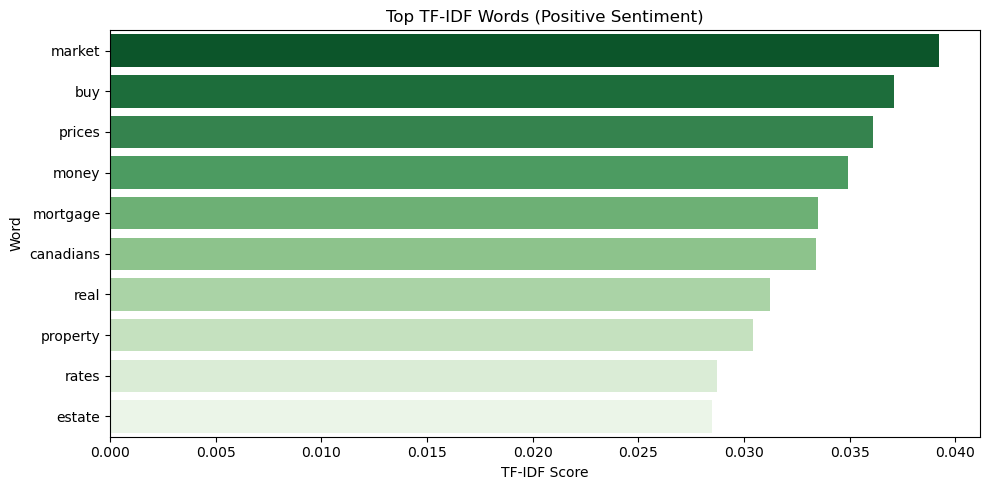

In [14]:
top_words = get_top_tfidf_words(pos_texts)

words, scores = zip(*top_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(scores), y=list(words), palette='Greens_r')
plt.title('Top TF-IDF Words (Positive Sentiment)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

In [15]:
df.shape

(200, 7)